In [44]:
import pandas as pd
import numpy as np
from numpy import NaN
import re
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import shapely

# Part 1 - Data Gathering

1. Make use of the API to find all aggravated burglary incidents () that were reported during the nine month period from January 1, 2022 through September 30, 2021. 

In [45]:

offense_type = "offense_description=BURGLARY- AGGRAVATED"
date_range = "$where=incident_reported between '2022-01-01T00:00:00' and '2022-09-30T23:59:59'"
endpoint = f'https://data.nashville.gov/resource/2u6v-ujjs.json?{offense_type}&{date_range}&$limit=25000'
response = requests.get(endpoint)

In [46]:
api_data = response.json()

In [47]:
agg_burglary_data_df = pd.DataFrame(api_data)

2. Census Information

In [48]:
census_tracts = pd.read_csv('data/census_tracts.csv')

# Part 2 - Spatial Joining and Data Merging

3. 2020 census tract shapes

In [49]:
census_tract_shapes = gpd.read_file('data/tl_2020_47_tract/tl_2020_47_tract.shp')

<AxesSubplot: >

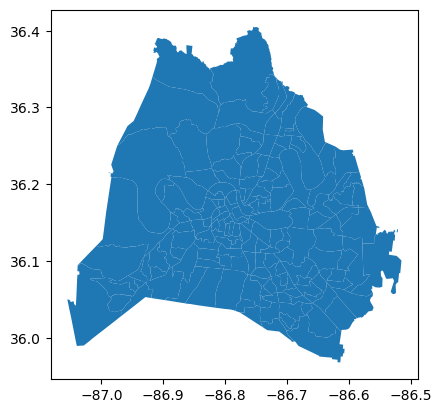

In [50]:
census_tract_shapes[census_tract_shapes['COUNTYFP']=='037'].plot()

In [51]:
davidson_county = census_tract_shapes[census_tract_shapes['COUNTYFP']=='037']

In [52]:
def coord_grabber(string):
    list = re.findall(r'\[([^]]+)\]',string)
    if len(list) == 1:
        return list[0]
    else:
        return list

In [53]:
test = agg_burglary_data_df['mapped_location']
coordinates = []

for elem in test:
    c = str(elem)
    coord = coord_grabber(c)
    coordinates.append(coord)

In [54]:
x = []
y = []
for string in coordinates:
    if type(string) == str:
        x.append(string.split(',')[0]) 
        y.append(string.split(',')[1])
    else:
        x.append(NaN)
        y.append(NaN)

In [55]:
agg_burglary_data_df['lat'] = y
agg_burglary_data_df['lng'] = x
agg_burglary_data_df[['lat', 'lng']] = agg_burglary_data_df[['lat', 'lng']].astype(float)

In [56]:
#Drop duplicate incidents of the same number, could be multiple victims for one burglary
agg_burglary_data_df = agg_burglary_data_df.drop_duplicates(subset=['incident_number'], keep='first')

In [57]:
agg_burglary_data_df['geometry'] = gpd.points_from_xy(agg_burglary_data_df['lng'], agg_burglary_data_df['lat'])

agg_burglary_data_df.head()

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,victim_race,victim_ethnicity,victim_county_resident,mapped_location,rpa,zone,zip_code,lat,lng,geometry
0,20220167824_11,20220167824,D,DISPATCHED,O,OPEN,Open,2022-04-07T15:00:00.000,2022-04-08T11:52:00.000,JACKSON ST,...,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.8, 36.17]}",NaN,NaN,NaN,36.17,-86.80,POINT (-86.80000 36.17000)
1,20220126184_31,20220126184,D,DISPATCHED,O,OPEN,Open,2022-03-18T02:30:00.000,2022-03-18T06:51:00.000,BENTON AVE,...,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.13]}",8029,817,NaN,36.13,-86.77,POINT (-86.77000 36.13000)
2,20220027854_12,20220027854,D,DISPATCHED,O,OPEN,Open,2022-01-18T07:45:00.000,2022-01-19T23:48:00.000,CANE RIDGE RD,...,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.66, 36.04]}",NaN,NaN,NaN,36.04,-86.66,POINT (-86.66000 36.04000)
3,20220032825_11,20220032825,D,DISPATCHED,O,OPEN,Open,2022-01-23T00:40:00.000,2022-01-24T06:57:00.000,BROOKWOOD TER,...,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.86, 36.13]}",5019,121,NaN,36.13,-86.86,POINT (-86.86000 36.13000)
4,20220010799_11,20220010799,D,DISPATCHED,O,OPEN,Open,2021-12-06T12:00:00.000,2022-01-21T16:25:00.000,SOUTH ST,...,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.15]}",6805,815,NaN,36.15,-86.78,POINT (-86.78000 36.15000)


In [58]:
burglary_geo = gpd.GeoDataFrame(agg_burglary_data_df, 
                           crs = davidson_county.crs, 
                           geometry = agg_burglary_data_df['geometry'])

In [59]:
burglary_geo.columns

Index(['primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'location_code', 'location_description',
       'offense_number', 'offense_nibrs', 'offense_description',
       'weapon_primary', 'weapon_description', 'victim_number',
       'domestic_related', 'victim_type', 'victim_description',
       'victim_gender', 'victim_race', 'victim_ethnicity',
       'victim_county_resident', 'mapped_location', 'rpa', 'zone', 'zip_code',
       'lat', 'lng', 'geometry'],
      dtype='object')

<AxesSubplot: >

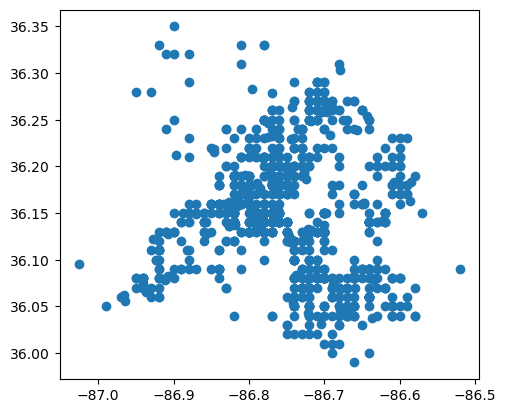

In [60]:
burglary_geo.plot()

In [61]:
burgs_by_tract = gpd.sjoin(burglary_geo, davidson_county, predicate='within',how='right')

In [62]:
print('These are the number of aggravated burglaries within in each of the census tracts in Davidson Co. \n Census tract 163 had the most:')
burgs_by_tract['NAME'].value_counts()

These are the number of aggravated burglaries within in each of the census tracts in Davidson Co. 
 Census tract 163 had the most:


163       31
160       28
143       23
142       21
113       19
          ..
183.02     1
187        1
101.03     1
189.02     1
178        1
Name: NAME, Length: 174, dtype: int64

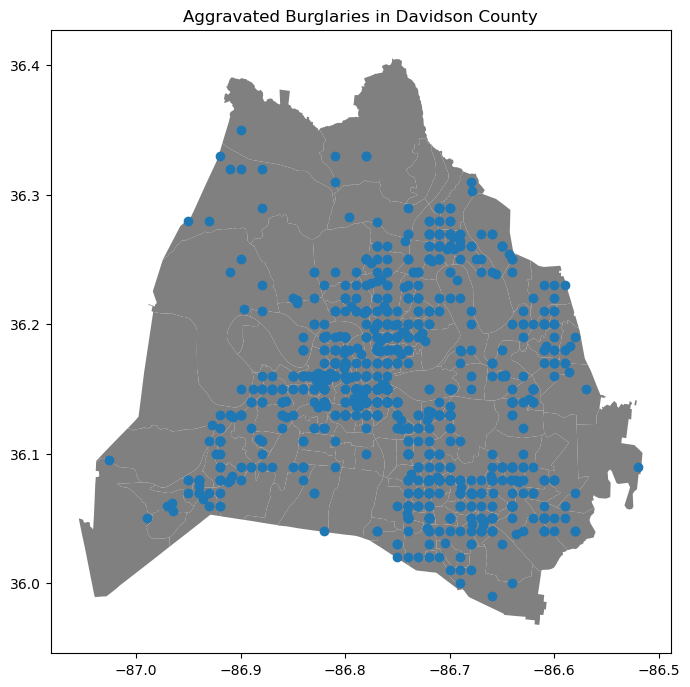

In [63]:
ax = davidson_county.plot(figsize = (8, 10), color = 'gray')
burglary_geo.plot(ax = ax)
ax.set_title('Aggravated Burglaries in Davidson County');

5. Merge census data 

In [64]:
#Adjust data types and column names to get ready for merge
burgs_by_tract['TRACTCE'] = burgs_by_tract['TRACTCE'].astype(int)
census_tracts = census_tracts.rename(columns={'tract':'TRACTCE'})

In [65]:
tracts_merged = pd.merge(burgs_by_tract, census_tracts, how='inner')
#Cleanup columns so we dont have unnecessary data
final_df_1 = tracts_merged[['incident_reported','geometry','TRACTCE','NAMELSAD', 'COUNTYFP', 'Population', 'median_income']]

In [66]:
final_df_1.head()

,incident_reported,geometry,TRACTCE,NAMELSAD,COUNTYFP,Population,median_income
0,2022-03-17T03:10:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001
1,2022-05-16T21:49:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001
2,2022-01-09T03:43:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001
3,2022-07-05T06:44:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001
4,2022-07-28T07:53:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001


In [67]:
#Get the number of burglaries for each census tract area
fill=final_df_1['TRACTCE'].value_counts()
fill=fill.reset_index().rename(columns={'index': 'TRACTCE', 'TRACTCE': 'total_num_burgs_in_tract'})
fill.head()

,TRACTCE,total_num_burgs_in_tract
0,16300,31
1,16000,28
2,14300,23
3,14200,21
4,11300,19


In [68]:
#Now add the total num burgs for each census tract area with another merge
final_df_2 = pd.merge(final_df_1,fill,how='inner')
final_df_2.head()

,incident_reported,geometry,TRACTCE,NAMELSAD,COUNTYFP,Population,median_income,total_num_burgs_in_tract
0,2022-03-17T03:10:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18
1,2022-05-16T21:49:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18
2,2022-01-09T03:43:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18
3,2022-07-05T06:44:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18
4,2022-07-28T07:53:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18


In [69]:
#Now add column to calculate the burgs per 1000 residents
pop = final_df_2['Population']
tot_burgs_tract = final_df_2['total_num_burgs_in_tract']

final_df_2['burgs_per_1000'] = tot_burgs_tract/pop*1000

top_burgs_per_1000 = final_df_2[final_df_2['burgs_per_1000'] == final_df_2['burgs_per_1000'].max()]

print('The census tract with the highest number of burglaries per 1000 residents is', top_burgs_per_1000['NAMELSAD'].unique()[0], 'with', final_df_2['burgs_per_1000'].max(), 'burglaries per 1000 people.')

The census tract with the highest number of burglaries per 1000 residents is Census Tract 143 with 14.22387136672851 burglaries per 1000 people.


# Part 3 - Statistical Modeling

6. Explain the number of agg. burglaries using the median income of each census tract

In [70]:
final_df_2.head()

,incident_reported,geometry,TRACTCE,NAMELSAD,COUNTYFP,Population,median_income,total_num_burgs_in_tract,burgs_per_1000
0,2022-03-17T03:10:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846
1,2022-05-16T21:49:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846
2,2022-01-09T03:43:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846
3,2022-07-05T06:44:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846
4,2022-07-28T07:53:00.000,"POLYGON ((-86.72632 36.07961, -86.72612 36.079...",19004,Census Tract 190.04,037,4470,44001,18,4.026846


In [71]:
median_income_pivot = (
            final_df_2
            .pivot_table(
                index = 'TRACTCE',
                values = ['median_income','Population','total_num_burgs_in_tract','burgs_per_1000']
            )
)
median_income_pivot.head()

,Population,burgs_per_1000,median_income,total_num_burgs_in_tract
TRACTCE,,,,
10103,2411,0.414766,60000,1
10104,3002,2.331779,84831,7
10105,4839,1.033271,61115,5
10106,2948,3.052917,66940,9
10201,4283,1.167406,69185,5


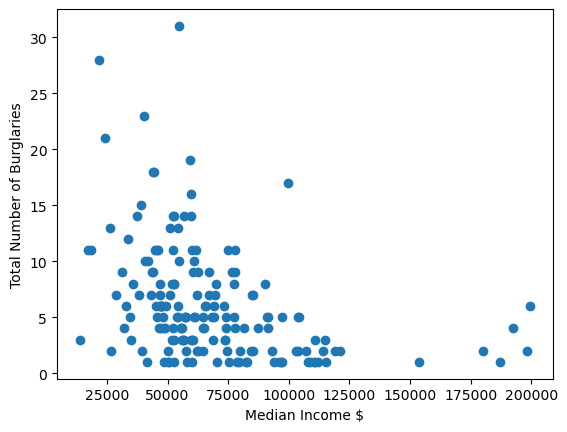

In [72]:
#Histogram with num burgs vs. median income
plt.scatter(median_income_pivot['median_income'], median_income_pivot['total_num_burgs_in_tract'])
plt.xlabel('Median Income $')
plt.ylabel('Total Number of Burglaries')
plt.show()

7. Poisson Regression for rate of burglaries per census tract, predictor being the median income. 

In [73]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson
from ipywidgets import interact, FloatSlider, IntSlider

In [74]:
p_fit = smf.glm('burgs_per_1000 ~ median_income',
                 data = median_income_pivot,
                 family = sm.families.Poisson()
                 ).fit()

p_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burgs_per_1000   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -284.19
Date:                Thu, 10 Nov 2022   Deviance:                       199.11
Time:                        20:19:01   Pearson chi2:                     288.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2707
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.6146      0.157     10.299      0.000       1.307       1.922
median_income -1.711e-05    2.6e-06     -6.585      0.000   -2.22e-05    -1.2e-05
=================================================================================
"""

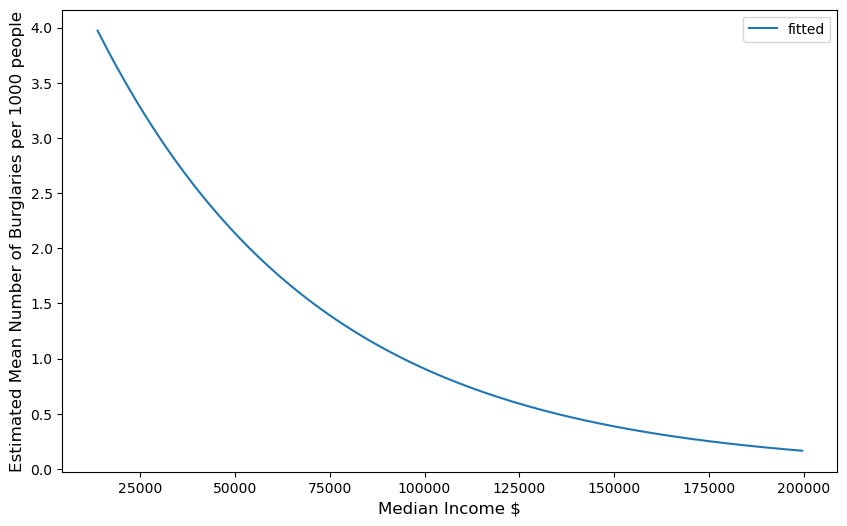

In [75]:
fit_df = pd.DataFrame({
    'median_income': np.linspace(start = median_income_pivot['median_income'].min(),
                       stop = median_income_pivot['median_income'].max(),
                       num = 150)
})
fit_df['fitted'] = p_fit.predict(fit_df)

fit_df.plot(x = 'median_income', y = 'fitted', figsize = (10,6))

fontsize = 12
plt.xlabel('Median Income $', fontsize = fontsize)
plt.ylabel('Estimated Mean Number of Burglaries per 1000 people', fontsize = fontsize);

In [76]:
@interact(median_income = IntSlider(value = 40, min = median_income_pivot['median_income'].min(), max = median_income_pivot['median_income'].max()))
def fit_plot(median_income):
    
    mu = np.exp(p_fit.params['Intercept'] + median_income * p_fit.params['median_income'])
    x = np.arange(start = 0, stop = 10, step = 1)
    y = poisson.pmf(x, mu = mu)

    plt.figure(figsize = (10,5))
    plt.bar(x, y, edgecolor = 'black')
    plt.xticks(x)
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Probability')
    plt.title(f'Estimated Distribution of Number of Burglaries\nmedian_income = {median_income}\n$\mu$={round(mu, 3)}');

interactive(children=(IntSlider(value=13750, description='median_income', max=199643, min=13750), Output()), _…

Log Offset to account for different Population Sizes

In [77]:
p_fit_2 = smf.glm('burgs_per_1000 ~ median_income',
                 data = median_income_pivot,
                 offset = np.log(median_income_pivot['Population']),
                 family = sm.families.Poisson()
                 ).fit()

p_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burgs_per_1000   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -344.96
Date:                Thu, 10 Nov 2022   Deviance:                       320.65
Time:                        20:19:04   Pearson chi2:                     661.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3239
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.4857      0.166    -38.961      0.000      -6.812      -6.159
median_income -2.044e-05   2.78e-06     -7.340      0.000   -2.59e-05    -1.5e-05
=================================================================================
"""

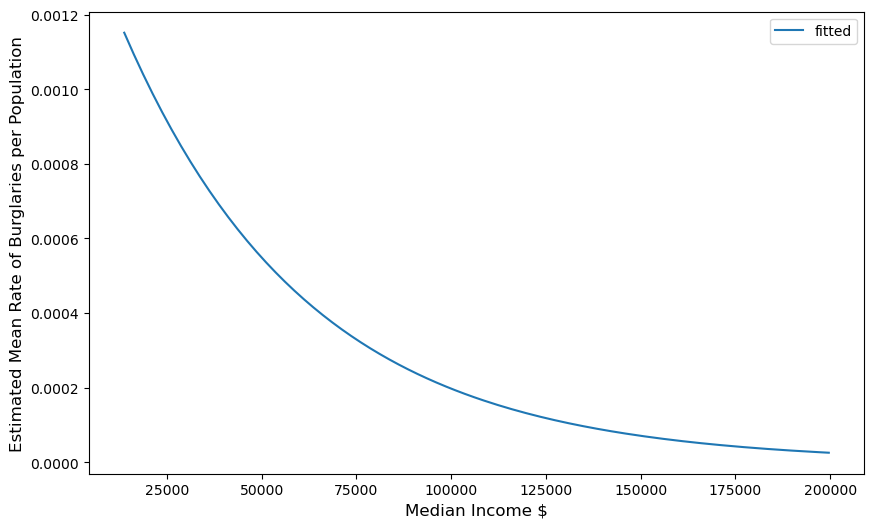

In [78]:
fit_df_2 = pd.DataFrame({
    'median_income': np.linspace(start = median_income_pivot['median_income'].min(),
                       stop = median_income_pivot['median_income'].max(),
                       num = 150)
})
fit_df_2['fitted'] = p_fit_2.predict(fit_df)

fit_df_2.plot(x = 'median_income', y = 'fitted', figsize = (10,6))

fontsize = 12
plt.xlabel('Median Income $', fontsize = fontsize)
plt.ylabel('Estimated Mean Rate of Burglaries per Population', fontsize = fontsize);